In [1]:
import numpy as np
import csv
import random

没考虑数据不平衡的问题
数据集太多，内存放不下

In [25]:
def data_split(datas,train_size =0.7,max_size=1000):
    """
    将数据划分为训练集和测试集
    :param datas: 数据
    :param train_size: 训练集比例
    :param max_size: 数据集的最大数量--不设置会因数据太多导致内存溢出！！
    :return: train_set,test_set: 训练集和测试集
    """
    np.random.seed(2023)
    data_size = len(datas)
    use_size = min(data_size,max_size) #选取不超过max_size条数据
    train_indices = np.random.choice(use_size,int(use_size*train_size),replace=False)
    test_indices = np.array(list(set(range(use_size))-set(train_indices)))
    train_set = np.array(datas)[train_indices]
    test_set = np.array(datas)[test_indices]
    return train_set,test_set

In [ ]:
# # Bag of words
# class Bow:
#     """词袋模型"""
#     def __init__(self,data):
#         self.data = data
#         self.word_dict = dict() #词典
#         self.dict_size = 0 #词典大小
#
#     def transfer_words(self):
#         """将data中的词转为向量"""
#         for term in self.data:
#             sentence = term[2]
#             sentence = sentence.lower() #转小写
#             words = sentence.split() #按照空格分词
#             for word in words:
#                 if word not in self.word_dict:#将未出现的词填入词典
#                     self.word_dict[word] = len(self.word_dict)
#         self.dict_size = len(self.word_dict) #更新词典大小
#


In [26]:
#N-gram
class N_Gram:
    """N元语法模型"""
    def __init__(self,data,n=2,max_size=1000):
        """
        :param data: 原始数据集
        :param n: n元语法
        :param max_size: 最大数据量--防止内存溢出
        """
        self.data = data[:max_size] #截取最大数据量
        self.n = n
        self.max_size = max_size
        self.diction_size = 0 #特征数量
        self.words_diction = dict() #词典
        self.train_set,self.test_set = data_split(data,train_size=0.7,max_size=self.max_size)
        self.train_y = [int(senten[3])for senten in self.train_set]
        self.test_y = [int(senten[3])for senten in self.test_set]
        self.train_matrix = np.zeros((len(self.train_set),self.diction_size))#初始化训练集向量
        self.test_matrix = np.zeros((len(self.test_set),self.diction_size)) #初始化测试集向量

    def get_words(self):
        for demention in range(1,self.n+1): #获取所有的1元短语到n元短语
            for data_line in self.data:
                senten = data_line[2]
                senten = senten.lower()
                words = senten.split()
                for i in range(len(words)-demention+1):
                    tmp = words[i:i+demention]
                    tmp = "_".join(tmp) #连接
                    if tmp not in self.words_diction:
                        self.words_diction[tmp] = len(self.words_diction) #填入词典
        self.diction_size = len(self.words_diction)
        #更新矩阵大小
        self.train_matrix = np.zeros((len(self.train_set),self.diction_size))
        self.test_matrix = np.zeros((len(self.test_set),self.diction_size))

    def get_matrix(self):
        for demention in range(1,self.n+1):
            for i in range(len(self.train_set)):
                sen = self.train_set[i][2] #一条文本数据
                sen = sen.lower()
                words = sen.split()
                for j in range(len(words) - demention +1):
                    tmp = words[j:j+demention]
                    tmp = "_".join(tmp)
                    self.train_matrix[i][self.words_diction[tmp]]=1 #设置向量的值
            for i in range(len(self.test_set)):
                sen = self.test_set[i][2]
                sen = sen.lower()
                words = sen.split()
                for j in range(len(words) -demention+1):
                    tmp = words[j:j+demention]
                    tmp = "_".join(tmp)
                    self.test_matrix[i][self.words_diction[tmp]]=1 #设置测试向量的值

In [18]:
#softmax函数
class Softmax:
    """Softmax"""
    def __init__(self,train_size,type_size,feature):
        """
        :param train_size: 训练集样本个数
        :param type_size: 分类种类数
        :param feature: 向量长度
        """
        self.train_size = train_size
        self.type_size = type_size
        self.feature = feature
        self.weight = np.random.randn(feature,type_size) #参数矩阵初始化

    def softmax_calculate(self,x):
        """
        计算向量的softmax值
        :param x: 向量
        :return: softmax value
        """
        exp = np.exp(x-np.max(x)) #防止指数太大溢出
        return exp/exp.sum()

    def softmax_all(self,wtx):
        """计算矩阵的softmax值"""
        wtx -= np.max(wtx,axis=1,keepdims=True)
        wtx = np.exp(wtx)
        wtx/=np.sum(wtx,axis=1,keepdims=True)
        return wtx

    def magic_y(self,y):
        """将种类转为one-hot向量"""
        res = np.array([0]*self.type_size)
        res[y] = 1
        return res.reshape(-1,1) #1xn的向量转为nx1的向量

    def predict(self,x):
        """对输入的向量x，判断句子的种类分布概率"""
        prob = self.softmax_all(x.dot(self.weight)) #向量乘法
        return prob.argmax(axis=1) #将概率最大的位置输出--种类

    def accuracy(self,train,train_y,test,test_y):
        """计算准确率Accuracy"""
        train_size = len(train)
        train_prediction = self.predict(train)
        train_accuracy = sum(train_y[i]==train_prediction[i] for i in range(train_size))/train_size

        test_size = len(test)
        test_prediction = self.predict(test)
        test_accuracy = sum(test_y[i]==test_prediction[i] for i in range(test_size))/test_size
        return train_accuracy,test_accuracy

    def regression(self,x,y,alpha,epoches,strategy="mini",mini_size=100):
        """softmax regression"""
        if self.train_size != len(x) or self.train_size != len(y):
            raise Exception("样本个数不匹配！")
        if strategy == "mini": #mini batch策略
            for i in range(epoches):
                increment = np.zeros((self.feature,self.type_size)) #梯度矩阵初始化
                for j in range(mini_size): #随机抽样k次
                    k = random.randint(0,self.type_size-1)
                    y_hat = self.softmax_calculate(self.weight.T.dot(x[k].reshape(-1,1)))#预测值
                    increment += x[k].reshape(-1,1).dot((self.magic_y(y[k])-y_hat).T) #计算梯度
                self.weight += alpha/mini_size * increment #更新参数
        elif strategy == "shuffle": #随机梯度下降
            for i in range(epoches):
                k = random.randint(0,self.train_size-1) #抽取一个
                y_hat = self.softmax_calculate(self.weight.T.dot(x[k].reshape(-1,1)))
                increment = x[k].reshape(-1,1).dot((self.magic_y(y[k]) - y_hat).T)
                self.weight += alpha*increment #更新参数
        elif strategy=="batch": #整批量梯度
            for i in range(epoches):
                increment = np.zeros((self.feature,self.type_size))
                for j in range(self.train_size):
                    y_hat = self.softmax_calculate(self.weight.T.dot(x[j].reshape(-1,1)))
                    increment += x[j].reshape(-1,1).dot((self.magic_y(y[j]) - y_hat).T)
                self.weight += alpha/self.train_size * increment
        else:
            raise Exception("无此策略")

In [28]:
#读取文件
train_filepath = "./sentiment-analysis-on-movie-reviews/train.tsv"
test_filepath = "./sentiment-analysis-on-movie-reviews/test.tsv"

with open(train_filepath)as f:
    fread = csv.reader(f,delimiter='\t')
    data = list(fread)

#去掉表头
data = data[1:]
len(data)

156060

In [30]:
import matplotlib.pyplot as plt

In [35]:
#训练-绘图
def model_plot(model,epoches,mini_size):
    alphas = [0.001,0.01,0.1,1,10,100,1000,10000]

    #mini-batch
    mini_train = list()
    mini_test = list()
    for alpha in alphas:
        soft = Softmax(len(model.train_set),5,model.diction_size)
        soft.regression(model.train_matrix,model.train_y,alpha,int(epoches/mini_size),"mini",mini_size)
        r_train,r_test = soft.accuracy(model.train_matrix,model.train_y,model.test_matrix,model.test_y)
        mini_train.append(r_train)
        mini_test.append(r_test)

    #绘制结果图
    plt.semilogx(alphas,mini_train,'r--',label='train') #横坐标采用对数格式
    plt.semilogx(alphas,mini_test,'b--',label="test")
    plt.title("N-gram")
    plt.xlabel("Learning Rate")
    plt.ylabel("Accuracy")
    plt.ylim(0,1)
    plt.show()


In [24]:
#n-元语法--特征提取--内存溢出版
model = N_Gram(data,2)
model.get_words()
print(model.diction_size)
model.get_matrix()

MemoryError: Unable to allocate 81.9 GiB for an array with shape (109242, 100663) and data type float64

In [37]:
#n-元语法--特征提取--正常版
model = N_Gram(data,2,10000)
model.get_words()
print(model.diction_size)
model.get_matrix()

8915


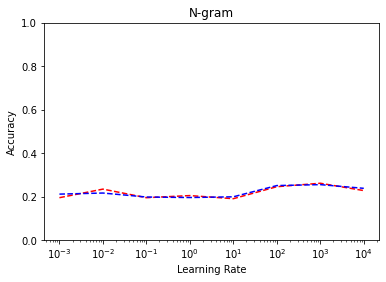

In [38]:
model_plot(model,10000,10)